# Exercise
- file name: `time_series_anomaly_detection.py` or `time_series_anomaly_detection.ipynb`

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

**Hint**: You will need to explore the database (yay SQL!)

1. Label students by the program they are in.
1. Is it possible to identify the user_id of a staff member?
1. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.
1. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2. 
1. Plot the access activity of these students.

**BONUS:** Can you identify users who are viewing both the web dev and data science curriculum?

In [1]:
# imports: 
import numpy as np
import pandas as pd
import seaborn as sns
import env

# graphs: 
import matplotlib.pyplot as plt

# warnings: 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# aquire the data:
url = url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/curriculum_logs'

In [3]:
df = pd.read_sql('''
SELECT name, program_id, date, time, path as endpoint, user_id, cohort_id, ip
FROM cohorts
LEFT JOIN logs
    on cohorts.id = logs.cohort_id''', url)

In [4]:
df.head()

,name,program_id,date,time,endpoint,user_id,cohort_id,ip
0,Arches,1,2018-01-31,15:52:32,javascript-i/arrays,11.0,1.0,97.105.19.61
1,Arches,1,2018-01-31,15:52:29,javascript-i,11.0,1.0,97.105.19.61
2,Arches,1,2018-01-31,14:59:38,javascript-i/arrays,11.0,1.0,97.105.19.61
3,Arches,1,2018-01-31,14:32:22,javascript-i,11.0,1.0,97.105.19.61
4,Arches,1,2018-01-31,14:32:19,javascript-i/arrays,11.0,1.0,97.105.19.61


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847336 entries, 0 to 847335
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   name        847336 non-null  object 
 1   program_id  847336 non-null  int64  
 2   date        847330 non-null  object 
 3   time        847330 non-null  object 
 4   endpoint    847329 non-null  object 
 5   user_id     847330 non-null  float64
 6   cohort_id   847330 non-null  float64
 7   ip          847330 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 51.7+ MB


# Prepare: 

In [6]:
# set the date to be the index
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

In [7]:
# resample the data: 
visits = df['endpoint'].resample('d').count()

# Exponetial moving average: 

In [8]:
# 7 Day EMA:
ema_7d = visits.ewm(span=7).mean()
ema_7d.head()

date
2018-01-26    533.000000
2018-01-27    359.857143
2018-01-28    276.891892
2018-01-29    461.982857
2018-01-30    511.811780
Name: endpoint, dtype: float64

In [9]:
# 14 Day EMA:
ema_14d = visits.ewm(span=14).mean()
ema_14d.head()

date
2018-01-26    533.000000
2018-01-27    370.678571
2018-01-28    293.254669
2018-01-29    443.081581
2018-01-30    487.673935
Name: endpoint, dtype: float64

In [10]:
# 30 Day EMA:
ema_30d = visits.ewm(span = 30).mean()
ema_30d.head()

date
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Name: endpoint, dtype: float64

In [11]:
# 90 Day EMA:
ema_90d = visits.ewm(span = 90).mean()
ema_90d.head()

date
2018-01-26    533.000000
2018-01-27    379.816667
2018-01-28    307.636352
2018-01-29    430.467642
2018-01-30    468.823433
Name: endpoint, dtype: float64

In [12]:
# 154 Day EMA:
ema_154d = visits.ewm(span=154).mean()
ema_154d.head()

date
2018-01-26    533.000000
2018-01-27    380.516234
2018-01-28    308.755527
2018-01-29    429.636211
2018-01-30    467.472881
Name: endpoint, dtype: float64

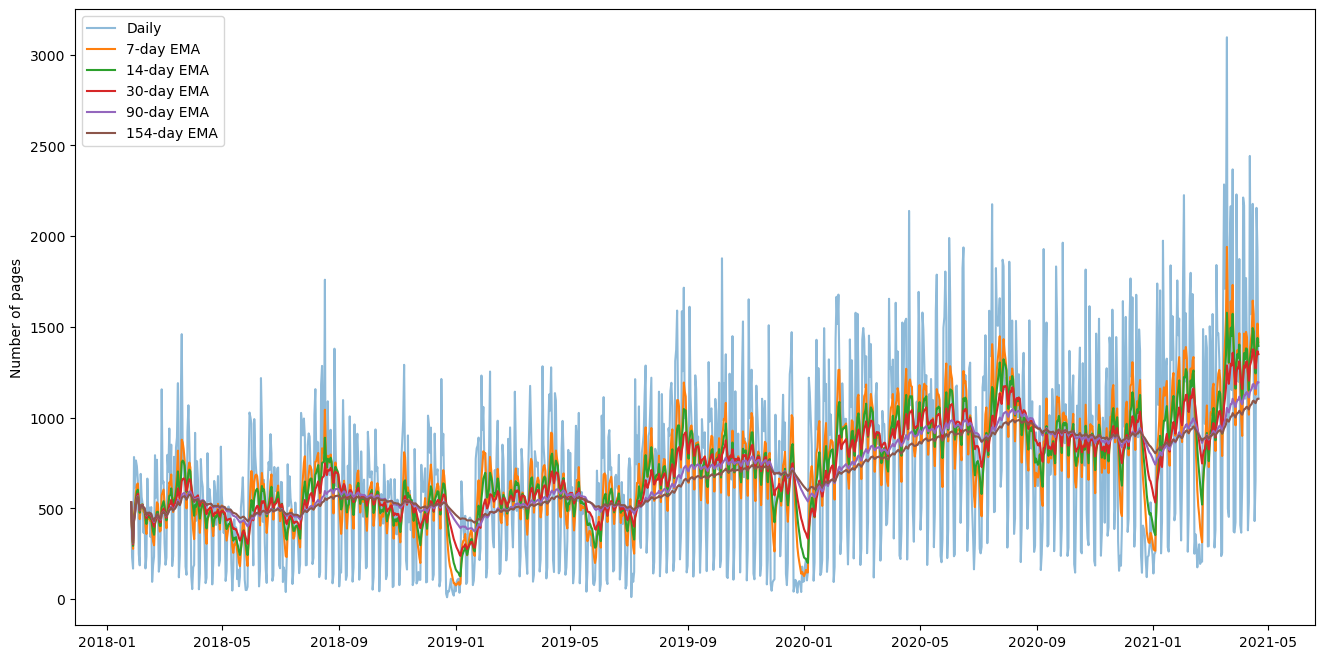

In [13]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(visits.index, visits, label='Daily', alpha=.5)

ax.plot(visits.index, ema_7d, label = '7-day EMA')
ax.plot(visits.index, ema_14d, label = '14-day EMA')
ax.plot(visits.index, ema_30d, label = '30-day EMA')
ax.plot(visits.index, ema_90d, label = '90-day EMA')
ax.plot(visits.index, ema_154d, label = '154-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

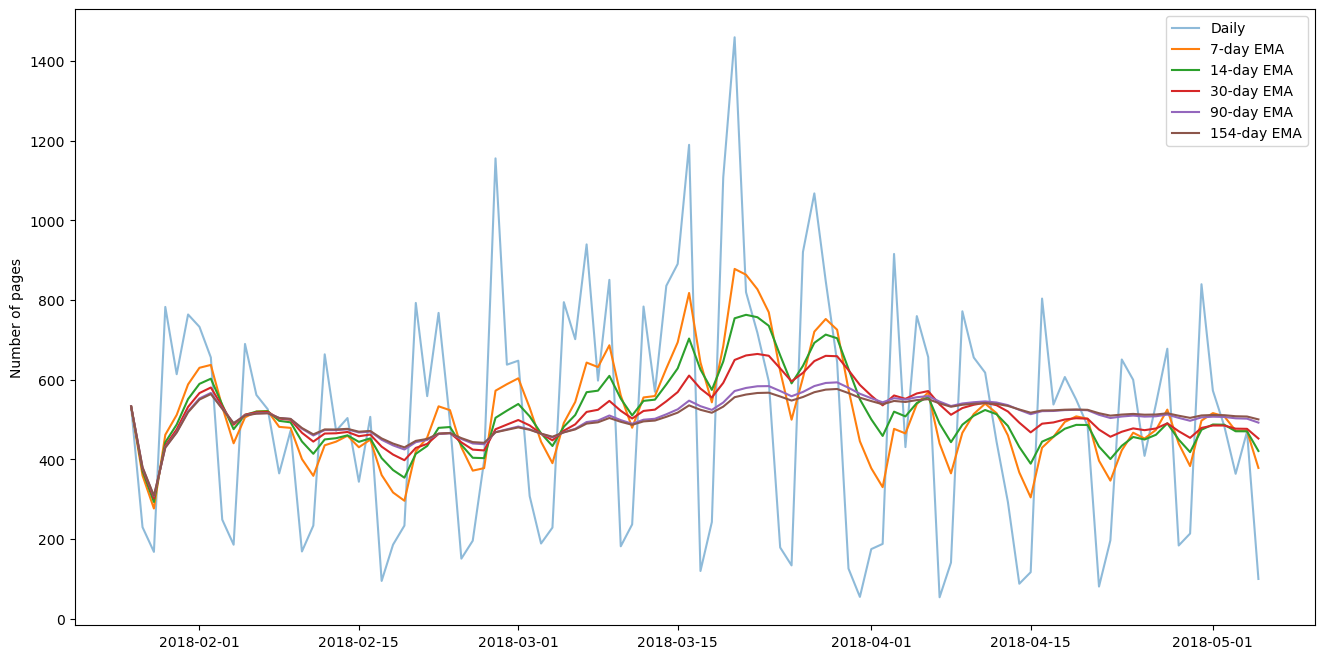

In [14]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(visits.index[:100], visits[:100], label='Daily', alpha=.5)
ax.plot(visits.index[:100], ema_7d[:100], label = '7-day EMA')
ax.plot(visits.index[:100], ema_14d[:100], label = '14-day EMA')
ax.plot(visits.index[:100], ema_30d[:100], label = '30-day EMA')
ax.plot(visits.index[:100], ema_90d[:100], label = '90-day EMA')
ax.plot(visits.index[:100], ema_154d[:100], label = '154-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

# Bollinger Bands

In [15]:
# set the window span
span = 30

# compute midband
midband = visits.ewm(span=span).mean()

midband.head()

date
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Name: endpoint, dtype: float64

In [16]:
# compute exponential stdev
stdev = visits.ewm(span=span).std()

stdev.head()

date
2018-01-26           NaN
2018-01-27    214.253355
2018-01-28    192.738756
2018-01-29    292.489456
2018-01-30    262.780177
Name: endpoint, dtype: float64

In [17]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub, lb

(date
 2018-01-26            NaN
 2018-01-27    1019.210064
 2018-01-28     880.500977
 2018-01-29    1312.207658
 2018-01-30    1263.865971
                  ...     
 2021-04-17    3539.572262
 2021-04-18    3480.391221
 2021-04-19    3565.644683
 2021-04-20    3575.685641
 2021-04-21    3495.320435
 Name: endpoint, Length: 1182, dtype: float64,
 date
 2018-01-26           NaN
 2018-01-27   -266.310064
 2018-01-28   -275.931559
 2018-01-29   -442.729079
 2018-01-30   -312.815089
                  ...    
 2021-04-17   -912.134710
 2021-04-18   -938.465770
 2021-04-19   -909.520874
 2021-04-20   -843.053691
 2021-04-21   -796.148610
 Name: endpoint, Length: 1182, dtype: float64)

In [18]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1019.210064,-266.310064
2018-01-28,880.500977,-275.931559
2018-01-29,1312.207658,-442.729079
2018-01-30,1263.865971,-312.815089


In [19]:
my_df = pd.concat([visits, midband, bb], axis=1)
my_df.columns = ['visits', 'midband', 'ub', 'lb']
my_df.head()

,visits,midband,ub,lb
date,,,,
2018-01-26,533,533.000000,NaN,NaN
2018-01-27,230,376.450000,1019.210064,-266.310064
2018-01-28,168,302.284709,880.500977,-275.931559
2018-01-29,783,434.739290,1312.207658,-442.729079
2018-01-30,614,475.525441,1263.865971,-312.815089


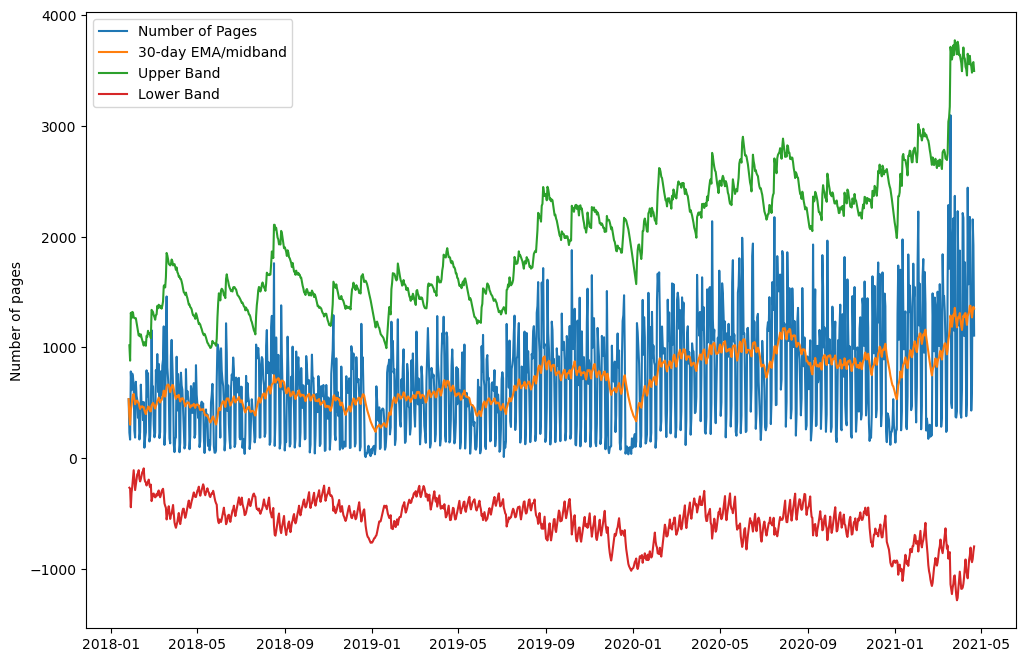

In [20]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.visits, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [21]:
# Visualize the last record in our dataset
my_df.iloc[-1]

visits     1107.000000
midband    1349.585912
ub         3495.320435
lb         -796.148610
Name: 2021-04-21 00:00:00, dtype: float64

In [22]:
# get the value of the last record
last_measure = my_df.iloc[-1].visits
last_measure

1107.0

In [23]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
last_lb

-796.1486103269135

In [24]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
last_ub

3495.320435064684

In [25]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.44


In [26]:
my_df['pct_b'] = (my_df['visits'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,visits,midband,ub,lb,pct_b
date,,,,,
2018-01-26,533,533.000000,NaN,NaN,NaN
2018-01-27,230,376.450000,1019.210064,-266.310064,0.386077
2018-01-28,168,302.284709,880.500977,-275.931559,0.383880
2018-01-29,783,434.739290,1312.207658,-442.729079,0.698446
2018-01-30,614,475.525441,1263.865971,-312.815089,0.587827


In [27]:
my_df[my_df['pct_b']>1]

,visits,midband,ub,lb,pct_b
date,,,,,


In [28]:
def acquire_logs(user=env.username, password=env.password, host=env.host):
    '''
    This function queries the Codeup MySQL curriculum_logs database and returns a dataframe
    '''
    url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/curriculum_logs'
    query = '''
    SELECT date,
           path as endpoint,
           user_id,
           cohort_id,
           ip as source_ip
    FROM logs;
    '''
    df = pd.read_sql(query, url)
    return df

In [29]:
def one_user_df_prep(df, user):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages_one_user = df['endpoint'].resample('d').count()
    return pages_one_user

In [30]:
def compute_pct_b(pages_one_user, span, weight, user):
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # Add upper and lower band values to dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Combine all data into a single dataframe
    my_df = pd.concat([pages_one_user, midband, bb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

In [31]:
def plot_bands(my_df, user):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

In [32]:
def find_anomalies(df, user, span, weight, plot=False):
    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''
    
    # Reduce dataframe to represent a single user
    pages_one_user = one_user_df_prep(df, user)
    
    # Add bollinger band data to dataframe
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    # Plot data if requested (plot=True)
    if plot:
        plot_bands(my_df, user)
    
    # Return only records that sit outside of bollinger band upper limit
    return my_df[my_df.pct_b>1]

In [33]:
df.head()

,name,program_id,date,time,endpoint,user_id,cohort_id,ip
date,,,,,,,,
2018-01-31,Arches,1,2018-01-31,15:52:32,javascript-i/arrays,11.0,1.0,97.105.19.61
2018-01-31,Arches,1,2018-01-31,15:52:29,javascript-i,11.0,1.0,97.105.19.61
2018-01-31,Arches,1,2018-01-31,14:59:38,javascript-i/arrays,11.0,1.0,97.105.19.61
2018-01-31,Arches,1,2018-01-31,14:32:22,javascript-i,11.0,1.0,97.105.19.61
2018-01-31,Arches,1,2018-01-31,14:32:19,javascript-i/arrays,11.0,1.0,97.105.19.61


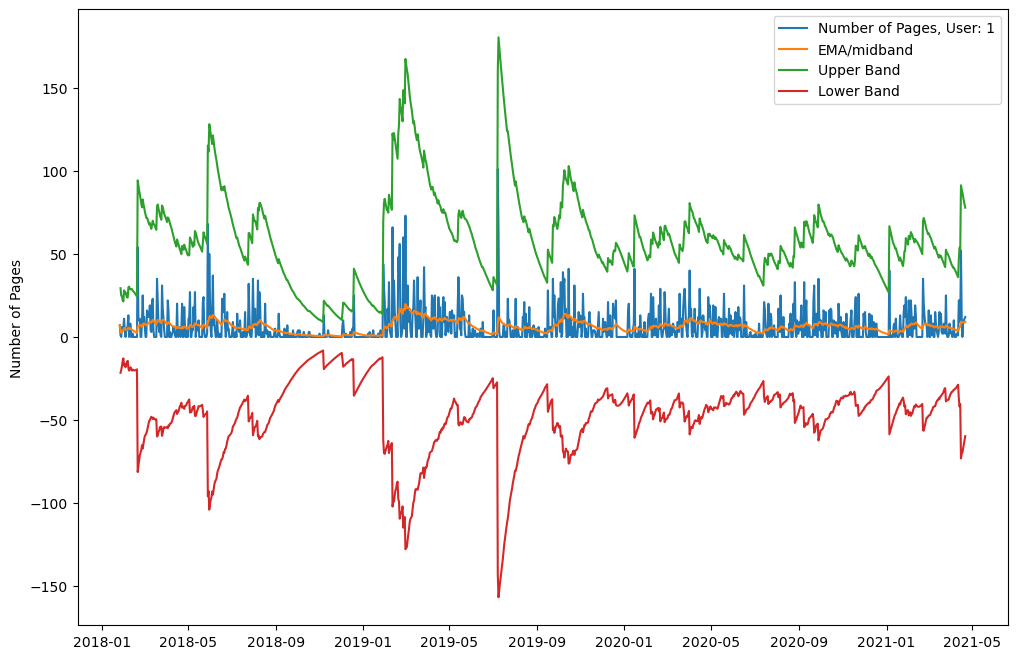

In [34]:
user = 1
span = 30
weight = 6
user_df = find_anomalies(df, user, span, weight, plot=True)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

In [35]:
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [36]:
anomalies

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1.0
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1.0
2018-07-09,7,0.830178,6.981464,-5.321108,1.001507,50.0
2018-09-08,10,0.944641,9.692466,-7.803183,1.017578,50.0
2019-03-03,13,0.861165,12.222179,-10.499849,1.034232,50.0
...,...,...,...,...,...,...
2020-08-04,40,2.829394,38.006319,-32.347531,1.028338,509.0
2020-06-21,4,0.258814,3.776692,-3.259063,1.031739,496.0
2020-07-29,29,2.160156,27.525162,-23.204851,1.029072,508.0


In [37]:
anomalies.sort_values(by='pages_one_user', ascending=False)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341.0
2018-06-02,198,16.484863,188.766965,-155.797239,1.026796,138.0
2019-12-19,192,19.601776,187.231096,-148.027544,1.014225,526.0
2020-10-16,179,20.158062,173.720239,-133.404115,1.017191,658.0
2020-06-05,165,20.035882,163.037501,-122.965736,1.006862,521.0
...,...,...,...,...,...,...
2019-09-16,1,0.064573,0.943175,-0.814029,1.032338,193.0
2020-09-02,1,0.064523,0.939315,-0.810269,1.034685,170.0
2020-03-16,1,0.064566,0.940141,-0.811010,1.034183,200.0


In [38]:
df_341 = one_user_df_prep(df, 341)

<Axes: xlabel='date'>

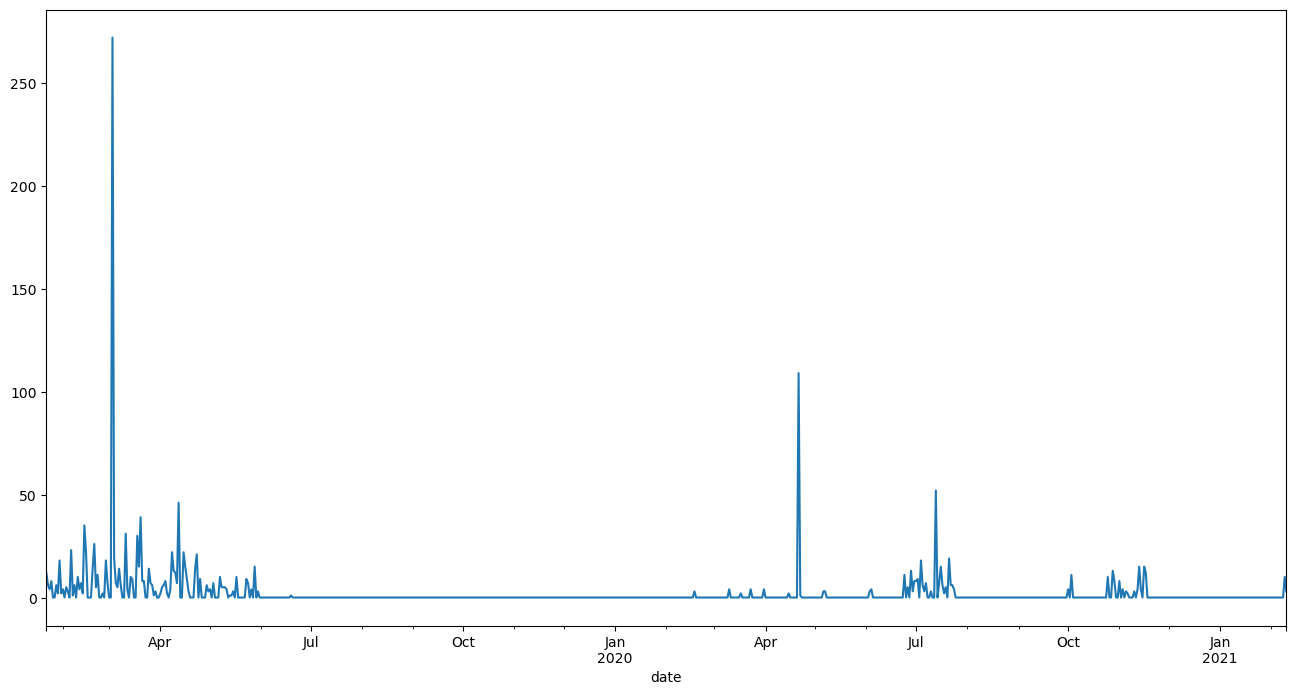

In [40]:
df_341.plot(figsize=(16,8))

In [41]:
anomalies.user_id.value_counts()

80.0     11
146.0    11
18.0     10
291.0     9
51.0      8
         ..
459.0     1
384.0     1
392.0     1
395.0     1
778.0     1
Name: user_id, Length: 380, dtype: int64